In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomCrop, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Train MobileNetV3
To train our neural network we need:
 - Load the data
 - Downscale data and prepare it for input
 - create some neccessary functions to show image, show scores and etc
 - Load MobileNetV3 pretrained model without top
 - Prepare Data augmentation layers
 - Prepare output layers
 - Set neccessary parameters
 - Train the model
 - evaluate the model performance
 - create pipeline 

#### parameters initialization

In [2]:
# We need to set seed for any randomizing that will happen during process
SEED = 44
# choose how much times we want data to be shown
epochs = 40
BATCH_SIZE = 32
# validation frequency so validation wont be run every epoch
VAL_FREQ = 2
OPTIMIZER = 'adam'
input_shape = (128,128,3)

# Create Data Loader
We need data loader to make loading batches computationally efficient and avoid memory issues

In [3]:
def load_from_directory(filename):
    data = tf.keras.utils.image_dataset_from_directory(filename,batch_size=BATCH_SIZE,image_size=(128,128),seed=SEED)
    return data

# We split our dataset into train and validation sets
def split_dir_dataset(data):
    # scale down rgb from 255 to 0
    data = data.map(lambda x,y: (x/255,y))
    
    # percent size of train and val sets
    train_size = int(len(data)*.85)
    val_size = int(len(data)*.15)
    
    # take that size images from dataset
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    
    print(f'training shape: {train.as_numpy_iterator().next()[0].shape}')
    return train,val

In [4]:
# path to our dataset
dataset_path = './multiclass'

data = load_from_directory(dataset_path)

train, val = split_dir_dataset(data)

Found 49525 files belonging to 8 classes.
training shape: (32, 128, 128, 3)


# Necessary Functions
Now we have to initialize necessary functions that we will use later


In [5]:
def show_samples_dataset(data):
    class_names = data.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
          
def show_results(hist,mode='acc'):
    if mode == 'acc' or mode == 'accuracy':
        mode = 'accuracy'
        val_mode = 'val_accuracy'
    elif mode == 'loss':
        mode = "loss"
        val_mode = "val_loss"
    
    fig = plt.figure()
    plt.plot(hist.history[mode], color='teal', label=mode)
    plt.plot(hist.history[val_mode], color='orange', label=val_mode)
    fig.suptitle(mode, fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
    
def prediction_dir_dataset(model,test):
    y_true = []
    y_pred = []
    for batch in test.as_numpy_iterator(): 
        X, y = batch
        yhat = model.predict(X)
        yhat = np.argmax(yhat,axis=1)
        y_true.append(y)
        y_pred.append(yhat)
    y_true = np.array(y_true)
    y_true = y_true.reshape(-1)
    y_pred = np.array(y_pred)
    y_pred = y_pred.reshape(-1)
    return y_true,y_pred

def scores(y_true,y_pred,show_confusion_matrix=True):
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    if show_confusion_matrix == True:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    print(f"precision weighted: {'{:.3f}'.format(precision_weighted)}\nprecision micro: {precision_micro} ")
    print(f'recall weighted: {recall_weighted}\nrecall micro: {recall_micro} ')
    print(f'f1 weighted: {"{:.3f}".format(f1_weighted)}\nf1 micro: {f1_micro} ')

# Add Data augmentation to our model

In [6]:
def data_augment(X):
    X = RandomCrop(height=96,width=96,seed=SEED)(X)
    X = RandomFlip(mode="horizontal_and_vertical",seed=SEED)(X)
    X = RandomRotation(factor=0.5)(X)
    X = RandomContrast(0.8,seed=SEED)(X)
    return X

# Load the model

In [7]:
base_model = MobileNetV3Large(input_shape=(96,96,3),weights='imagenet',include_top=False,include_preprocessing=False)


In [8]:
# initialize input shape layer for data augmentation block
x_input = Input(input_shape)
x = data_augment(x_input)

# connect data augmentation block to base model
x = base_model(x)


# Global spatial avg pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layer
x = Dense(1024,activation='relu')(x)

# We have 2 classes either it is suitable for children or not but for now we train for multiclass classification
# which means softmax distribution over 8 classes
predictions = Dense(8,activation='softmax')(x)

# this is the model we will train
model = Model(inputs=x_input, outputs=predictions)

In [9]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional MobileNetV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# add Early stopping callback to stop model before it overfits the data
callback = EarlyStopping(monitor='val_loss',patience=5,verbose=1)


In [10]:
# visualize model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
random_crop (RandomCrop)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 96, 96, 3)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 96, 96, 3)         0         
_________________________________________________________________
random_contrast (RandomContr (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0     

In [11]:
# initialize this so computing is more efficient
AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.cache()
train = train.prefetch(buffer_size=AUTOTUNE)

In [12]:
# train the model on the new data for a few epochs
epochs = 10
hist = model.fit(train,
                 epochs = epochs,
                 validation_data=val,
                 callbacks = [callback],
                 validation_freq=VAL_FREQ)

Epoch 1/10
1315/1315 [==============================] - 52s 34ms/step - loss: 0.6072 - accuracy: 0.7958
Epoch 2/10
1315/1315 [==============================] - 77s 59ms/step - loss: 0.5267 - accuracy: 0.8211 - val_loss: 0.4039 - val_accuracy: 0.8695
Epoch 3/10
1315/1315 [==============================] - 26s 20ms/step - loss: 0.4950 - accuracy: 0.8322
Epoch 4/10
1315/1315 [==============================] - 76s 58ms/step - loss: 0.4819 - accuracy: 0.8362 - val_loss: 0.4025 - val_accuracy: 0.8634
Epoch 5/10
1315/1315 [==============================] - 27s 20ms/step - loss: 0.4650 - accuracy: 0.8423
Epoch 6/10
1315/1315 [==============================] - 77s 58ms/step - loss: 0.4605 - accuracy: 0.8441 - val_loss: 0.3935 - val_accuracy: 0.8734
Epoch 7/10
1315/1315 [==============================] - 26s 20ms/step - loss: 0.4512 - accuracy: 0.8478
Epoch 8/10
1315/1315 [==============================] - 77s 58ms/step - loss: 0.4384 - accuracy: 0.8508 - val_loss: 0.4238 - val_accuracy: 0.8654


In [14]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from MobileNet V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

NameError: name 'base_model' is not defined

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=OPTIMIZER), loss=tf.losses.SparseCategoricalCrossentropy())

In [ ]:
# we train our model again, this time fine-tuning the convolutional layers
# alongside the top Dense layers
epochs = 50
hist_unfreezed = model.fit(train,
                           epochs = epochs,
                           validation_data=val,
                           callbacks = [callback],
                           validation_freq=VAL_FREQ)

#  https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [40]:

def predict(img_path):
    # img_path = 'dawg.jpg'
    img = load_img(img_path, target_size=(128, 128))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    predicted_idx = np.argmax(preds)
    predicted_class = data.class_names[predicted_idx]
    print(predicted_class) 

In [42]:
predict("images (1).jpeg")

people_big


In [44]:
data.class_names

['animals_img',
 'drugs',
 'illegal',
 'memes',
 'people_big',
 'porn',
 'skin_images',
 'weapon_images']

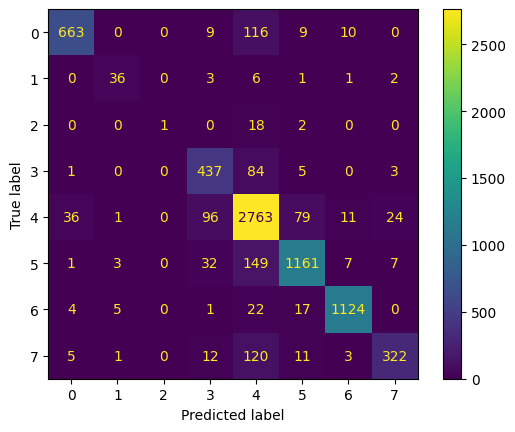

precision weighted: 0.881
precision micro: 0.8764816810344828 
recall weighted: 0.8764816810344828
recall micro: 0.8764816810344828 
f1 weighted: 0.875
f1 micro: 0.8764816810344828 


In [43]:
y_true,y_pred = prediction_dir_dataset(model,val)
scores(y_true,y_pred,show_confusion_matrix=True)